<a href="https://colab.research.google.com/github/pablovitoria/business_analysis_structured_data/blob/main/scripts/A1%3A%20Modeling%20Case%20Study%20-%20Bike%20Rentals%20in%20Chicago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXECUTIVE SUMMARY

Some qualitative info:
"Service alert: Due to the upcoming subzero temperatures forecasted, some ebikes and scooters may be unavailable for use. Classic bikes availability shouldn’t be impacted." Currently on the website

ANSWER TO FIRST QUESTION
Based on your analysis, are the majority of rentals for leisure, exercise, or commuting to work? Provide data-driven evidence for your claim, as well as at least one source from external research.

* Quick intro on how succesful (A Tale of Two Divvys: The Bicycle Sharing System of Chicago — Bergman (2024, Sustainability).)

*




In [1]:
# Notebook set-up
# Cloning GitHub Repo
!git clone https://github.com/pablovitoria/business_analysis_structured_data

# Changing directory
import os
repo_name = '/content/business_analysis_structured_data'
os.chdir(repo_name)

# Checking results
print(f"Current working directory changed to: {os.getcwd()}")

Cloning into 'business_analysis_structured_data'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 76 (delta 39), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 486.60 KiB | 11.87 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Current working directory changed to: /content/business_analysis_structured_data


In [2]:
# importing packages
import pandas as pd                                  # data science essentials
import matplotlib.pyplot as plt                      # data viz
import seaborn as sns                                # enhanced data viz
import statsmodels.formula.api as smf                # linear modeling
from sklearn.model_selection import train_test_split # train/test split
import sklearn.linear_model                          # faster linear modeling
import numpy as np                                   # mathematical essentials\
import warnings

# Suppressing user warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Storing the path to the dataset
file = "./datasets/bike_rentals.xlsx"


# Reading the file into Python through pandas
bikerentals = pd.read_excel(io = file,
                            usecols = range(1, 15)) # omitting ID column

In [3]:
# Better dataframe readability:
# Making all column names lowercase and replace spaces with underscores
bikerentals.columns = (
                        bikerentals.columns
                        .str.lower()            #lowercase
                        .str.replace(" ", "_")  #replace spaces
                        )

# Making holiday a boolean
bikerentals["holiday"] = (
                          bikerentals["holiday"]
                          .str.strip()
                          .str.lower()
                          .map({"yes": 1, "no": 0}))

In [6]:
bikerentals["holiday"].unique()

array([1, 0])

In [4]:
# Creating new variable to identify working days
# Working day = during the week (not weekend) and not a holiday
# Will be used as a proxy to identify commuters
bikerentals["is_working_day"] = (
    (bikerentals["day_of_week"] != "Saturday") &
    (bikerentals["day_of_week"] != "Sunday") &
    (bikerentals["holiday"] == 0)
).astype(int)

<Axes: xlabel='is_working_day', ylabel='rentals'>

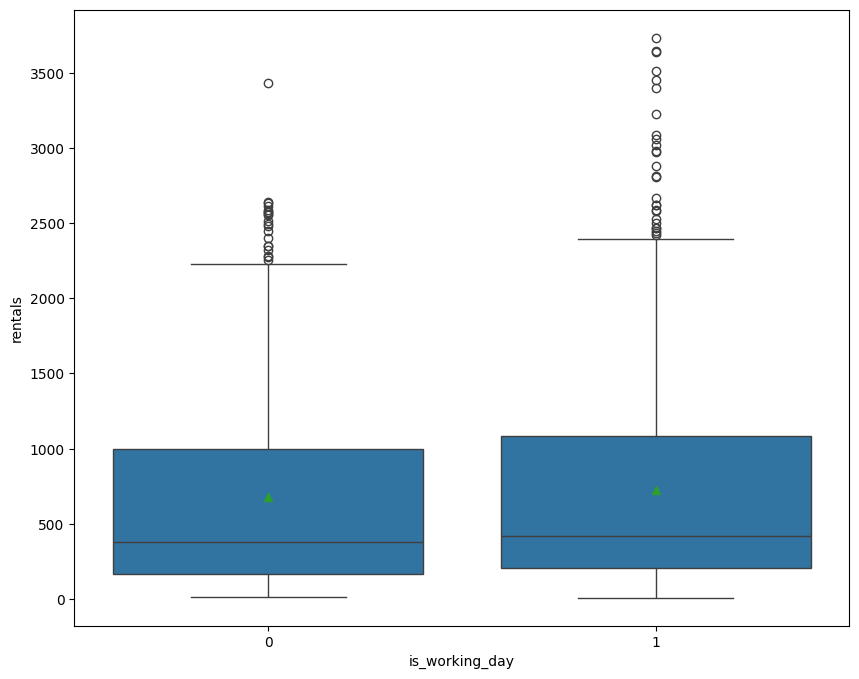

In [7]:
# Understanding if there is a difference
fig, ax = plt.subplots(figsize = (10, 8))

sns.boxplot(x    = 'is_working_day',
                y    = 'rentals',
                data = bikerentals,
                showmeans=True)

We definetly see a difference of about XYZ in the means for both groups. This points out that the bikes are used more during working days - which is an indicator that bikes could be using for communiting. Another proxy is the times where the bikes are used.

Peak hour definition: https://teamjustice.com/chicago-rush-hour-traffic/.

For a given working day:

In [18]:
bikerentals["is_peak_hour"] = (
    bikerentals["hour"].isin([7, 8, 9, 16, 17, 18, 19])
).astype(int)


<Axes: xlabel='is_peak_hour', ylabel='rentals'>

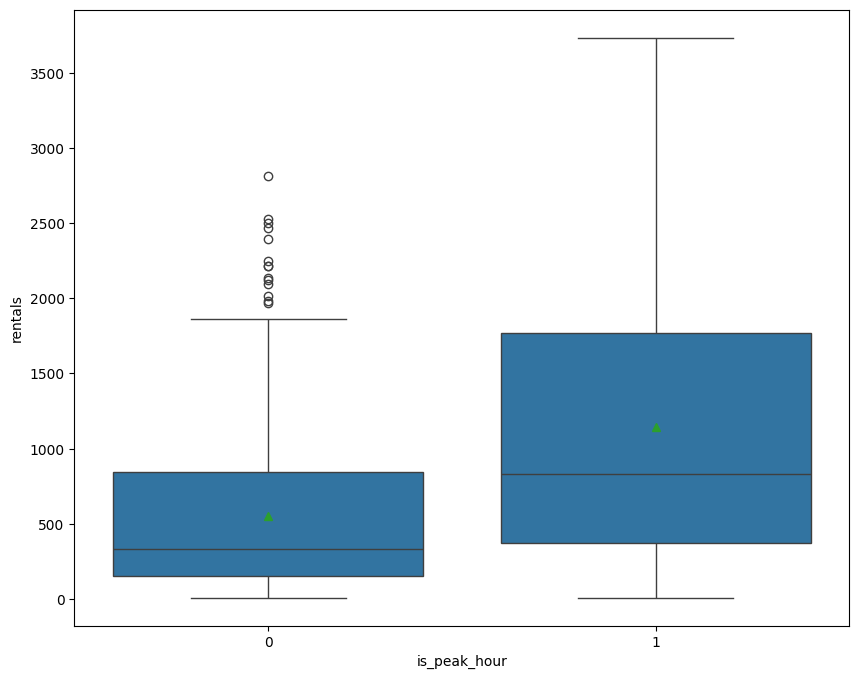

In [17]:
# Understanding if there is a difference
fig, ax = plt.subplots(figsize = (10, 8))

sns.boxplot(x    = 'is_peak_hour',
                y    = 'rentals',
                 data=bikerentals[bikerentals["is_working_day"] == 1],
                showmeans=True)

To do for question 1:
- Time series for hour of the day ( to confirm peak hours)
- Showing hours on weekends? Maybe to also say for leasure
- Showing differences in weekends and holidays based on weather vs differences in working days when weather is shit so we say that under the assumption that people communit are less elastic then we can confirm that

REVIEW DATA TYPE FOR HOLIDAY

# Question 2

## Dealing with categorical variables

In [19]:
bikerentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   month                  1029 non-null   object 
 1   day_of_week            1029 non-null   object 
 2   hour                   1029 non-null   int64  
 3   temperature            1029 non-null   float64
 4   humidity               1029 non-null   int64  
 5   wind_speed             1029 non-null   float64
 6   visibility             1029 non-null   int64  
 7   dew_point_temperature  1029 non-null   float64
 8   uv_index               1029 non-null   float64
 9   rainfall               1029 non-null   float64
 10  snowfall               1029 non-null   float64
 11  seasons                1029 non-null   object 
 12  holiday                1029 non-null   int64  
 13  rentals                1029 non-null   int64  
 14  is_working_day         1029 non-null   int64  
 15  is_p

Seems like we need to one hot encode: month, day_of_week, seasons. Let's first check their histograms


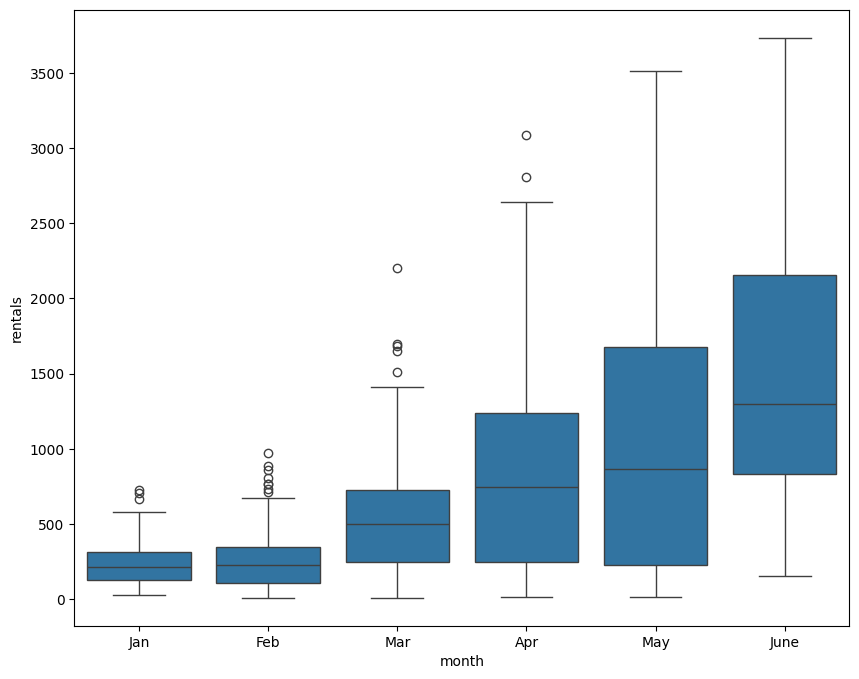

In [20]:
    fig, ax = plt.subplots(figsize = (10, 8))

    sns.boxplot(x    = 'month',
                y    = 'rentals',
                data = bikerentals)

    plt.suptitle("")
    plt.show()

In [21]:
bikerentals["month"].value_counts()

,count
month,
Jan,189
May,181
Apr,173
Mar,166
Feb,162
June,158


YES TO ONE HOT

Seasonal activity detected
- data from Jan to June in the dataset

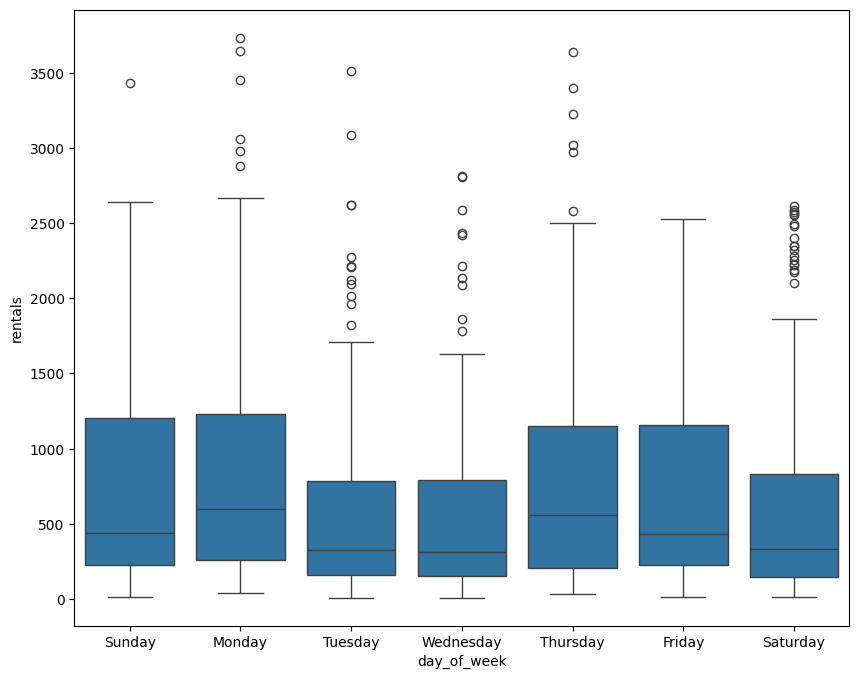

In [22]:
    fig, ax = plt.subplots(figsize = (10, 8))

    sns.boxplot(x    = 'day_of_week',
                y    = 'rentals',
                data = bikerentals)

    plt.suptitle("")
    plt.show()

In [23]:
bikerentals["day_of_week"].value_counts()

,count
day_of_week,
Monday,161
Friday,161
Saturday,158
Thursday,149
Tuesday,138
Wednesday,136
Sunday,126


YES TO ONE HOT

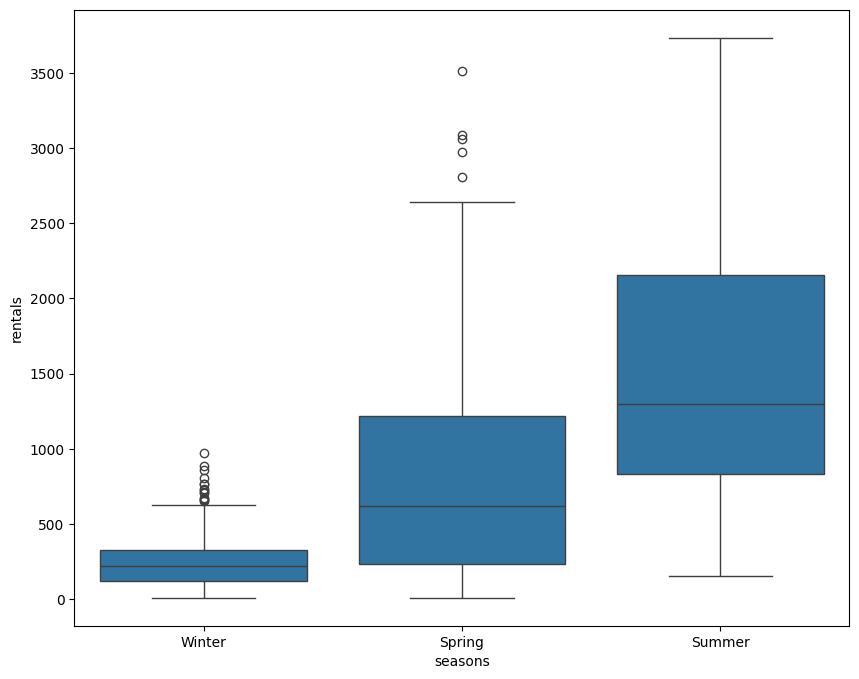

In [24]:
    fig, ax = plt.subplots(figsize = (10, 8))

    sns.boxplot(x    = 'seasons',
                y    = 'rentals',
                data = bikerentals)

    plt.suptitle("")
    plt.show()

In [25]:
bikerentals["seasons"].value_counts()

,count
seasons,
Spring,520
Winter,351
Summer,158


### ONE HOT ENCODE

In [26]:
# one hot encoding categorical variables
one_hot_month = pd.get_dummies(data   = bikerentals['month'],
                          prefix = 'month',
                          dtype  = int)

one_hot_month.value_counts()

month_Apr  month_Feb  month_Jan  month_June  month_Mar  month_May
0          0          1          0           0          0            189
                      0          0           0          1            181
1          0          0          0           0          0            173
0          0          0          0           1          0            166
           1          0          0           0          0            162
           0          0          1           0          0            158
Name: count, dtype: int64

In [27]:
# one hot encoding categorical variables
one_hot_dow = pd.get_dummies(data   = bikerentals['day_of_week'],
                          prefix = 'dow',
                          dtype  = int)

one_hot_dow.value_counts()

dow_Friday  dow_Monday  dow_Saturday  dow_Sunday  dow_Thursday  dow_Tuesday  dow_Wednesday
1           0           0             0           0             0            0                161
0           1           0             0           0             0            0                161
            0           1             0           0             0            0                158
                        0             0           1             0            0                149
                                                  0             1            0                138
                                                                0            1                136
                                      1           0             0            0                126
Name: count, dtype: int64

In [28]:
# one hot encoding categorical variables
one_hot_seasons = pd.get_dummies(data   = bikerentals['seasons'],
                          prefix = 'seasons',
                          dtype  = int)

one_hot_seasons.value_counts()

seasons_Spring  seasons_Summer  seasons_Winter
1               0               0                 520
0               0               1                 351
                1               0                 158
Name: count, dtype: int64

In [29]:
bikerentals2 = bikerentals.join([one_hot_month, one_hot_dow, one_hot_seasons])
bikerentals2.head(n=5)

,month,day_of_week,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,uv_index,rainfall,...,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday,seasons_Spring,seasons_Summer,seasons_Winter
0,Jan,Sunday,0,-3.2,40,0.5,1358,-14.9,0.00,0.0,...,0,0,0,1,0,0,0,0,0,1
1,Jan,Sunday,3,-4.0,44,1.0,2000,-14.4,0.00,0.0,...,0,0,0,1,0,0,0,0,0,1
2,Jan,Sunday,13,2.4,22,2.3,1921,-17.2,1.10,0.0,...,0,0,0,1,0,0,0,0,0,1
3,Jan,Sunday,16,3.0,28,2.5,1864,-13.7,0.51,0.0,...,0,0,0,1,0,0,0,0,0,1
4,Jan,Sunday,17,1.8,33,3.3,1913,-12.8,0.18,0.0,...,0,0,0,1,0,0,0,0,0,1


In [30]:
# renaming channels and storing as diamonds (not diamonds2)
bikerentals2.rename(columns = {'dow_Monday': 'monday',
                            'dow_Tuesday': 'tuesday',
                            'dow_Wednesday': 'wednesday',
                            'dow_Thursday': 'thursday',
                            'dow_Friday': 'friday',
                            'dow_Saturday': 'saturday',
                            'dow_Sunday': 'sunday',
                            'month_Jan': 'jan',
                            'month_Feb': 'feb',
                            'month_Mar': 'mar',
                            'month_Apr': 'apr',
                            'month_May': 'may',
                            'month_June': 'jun',
                            'seasons_Spring': 'spring',
                            'seasons_Summer':'summer',
                            'seasons_Fall': 'fall',
                            'seasons_Winter': 'winter'
                            },
                inplace = True)


# checking results
bikerentals2.head(n = 5)

,month,day_of_week,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,uv_index,rainfall,...,friday,monday,saturday,sunday,thursday,tuesday,wednesday,spring,summer,winter
0,Jan,Sunday,0,-3.2,40,0.5,1358,-14.9,0.00,0.0,...,0,0,0,1,0,0,0,0,0,1
1,Jan,Sunday,3,-4.0,44,1.0,2000,-14.4,0.00,0.0,...,0,0,0,1,0,0,0,0,0,1
2,Jan,Sunday,13,2.4,22,2.3,1921,-17.2,1.10,0.0,...,0,0,0,1,0,0,0,0,0,1
3,Jan,Sunday,16,3.0,28,2.5,1864,-13.7,0.51,0.0,...,0,0,0,1,0,0,0,0,0,1
4,Jan,Sunday,17,1.8,33,3.3,1913,-12.8,0.18,0.0,...,0,0,0,1,0,0,0,0,0,1


In [33]:
bikerentals_complete = bikerentals2.drop(['monday',   # category to drop
                           'jan',  # already factorized
                           'spring',    # not enough samples per store
                            'day_of_week',
                            'month',
                            'seasons'
                          ], axis = 1)

In [36]:
#sorting the dataset for better readability
new_order = [
    "rentals",                  # y-variable
    "hour",
    "temperature",
    "humidity",
    "wind_speed",
    "visibility",
    "dew_point_temperature",
    "uv_index",
    "rainfall",
    "snowfall",
    "holiday",
    "is_working_day",
    "is_peak_hour",
    "feb",                    #month dummies (Jan is baseline)
    "mar",
    "apr",
    "may",
    "jun",
    "tuesday",                #days dummies (Monday is baseline)
    "wednesday",
    "thursday",
    "friday",
    "saturday",
    "sunday",
    "summer",                #season dummies (Spring is baseline)
    "winter"
]

bikerentals_complete = bikerentals_complete[new_order]

bikerentals_complete.head()


,rentals,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,uv_index,rainfall,snowfall,...,may,jun,tuesday,wednesday,thursday,friday,saturday,sunday,summer,winter
0,221,0,-3.2,40,0.5,1358,-14.9,0.00,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
1,130,3,-4.0,44,1.0,2000,-14.4,0.00,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
2,268,13,2.4,22,2.3,1921,-17.2,1.10,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
3,335,16,3.0,28,2.5,1864,-13.7,0.51,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
4,299,17,1.8,33,3.3,1913,-12.8,0.18,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1


In [39]:
bikerentals_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   rentals                1029 non-null   int64  
 1   hour                   1029 non-null   int64  
 2   temperature            1029 non-null   float64
 3   humidity               1029 non-null   int64  
 4   wind_speed             1029 non-null   float64
 5   visibility             1029 non-null   int64  
 6   dew_point_temperature  1029 non-null   float64
 7   uv_index               1029 non-null   float64
 8   rainfall               1029 non-null   float64
 9   snowfall               1029 non-null   float64
 10  holiday                1029 non-null   int64  
 11  is_working_day         1029 non-null   int64  
 12  is_peak_hour           1029 non-null   int64  
 13  feb                    1029 non-null   int64  
 14  mar                    1029 non-null   int64  
 15  apr 

YES TO SEASONS

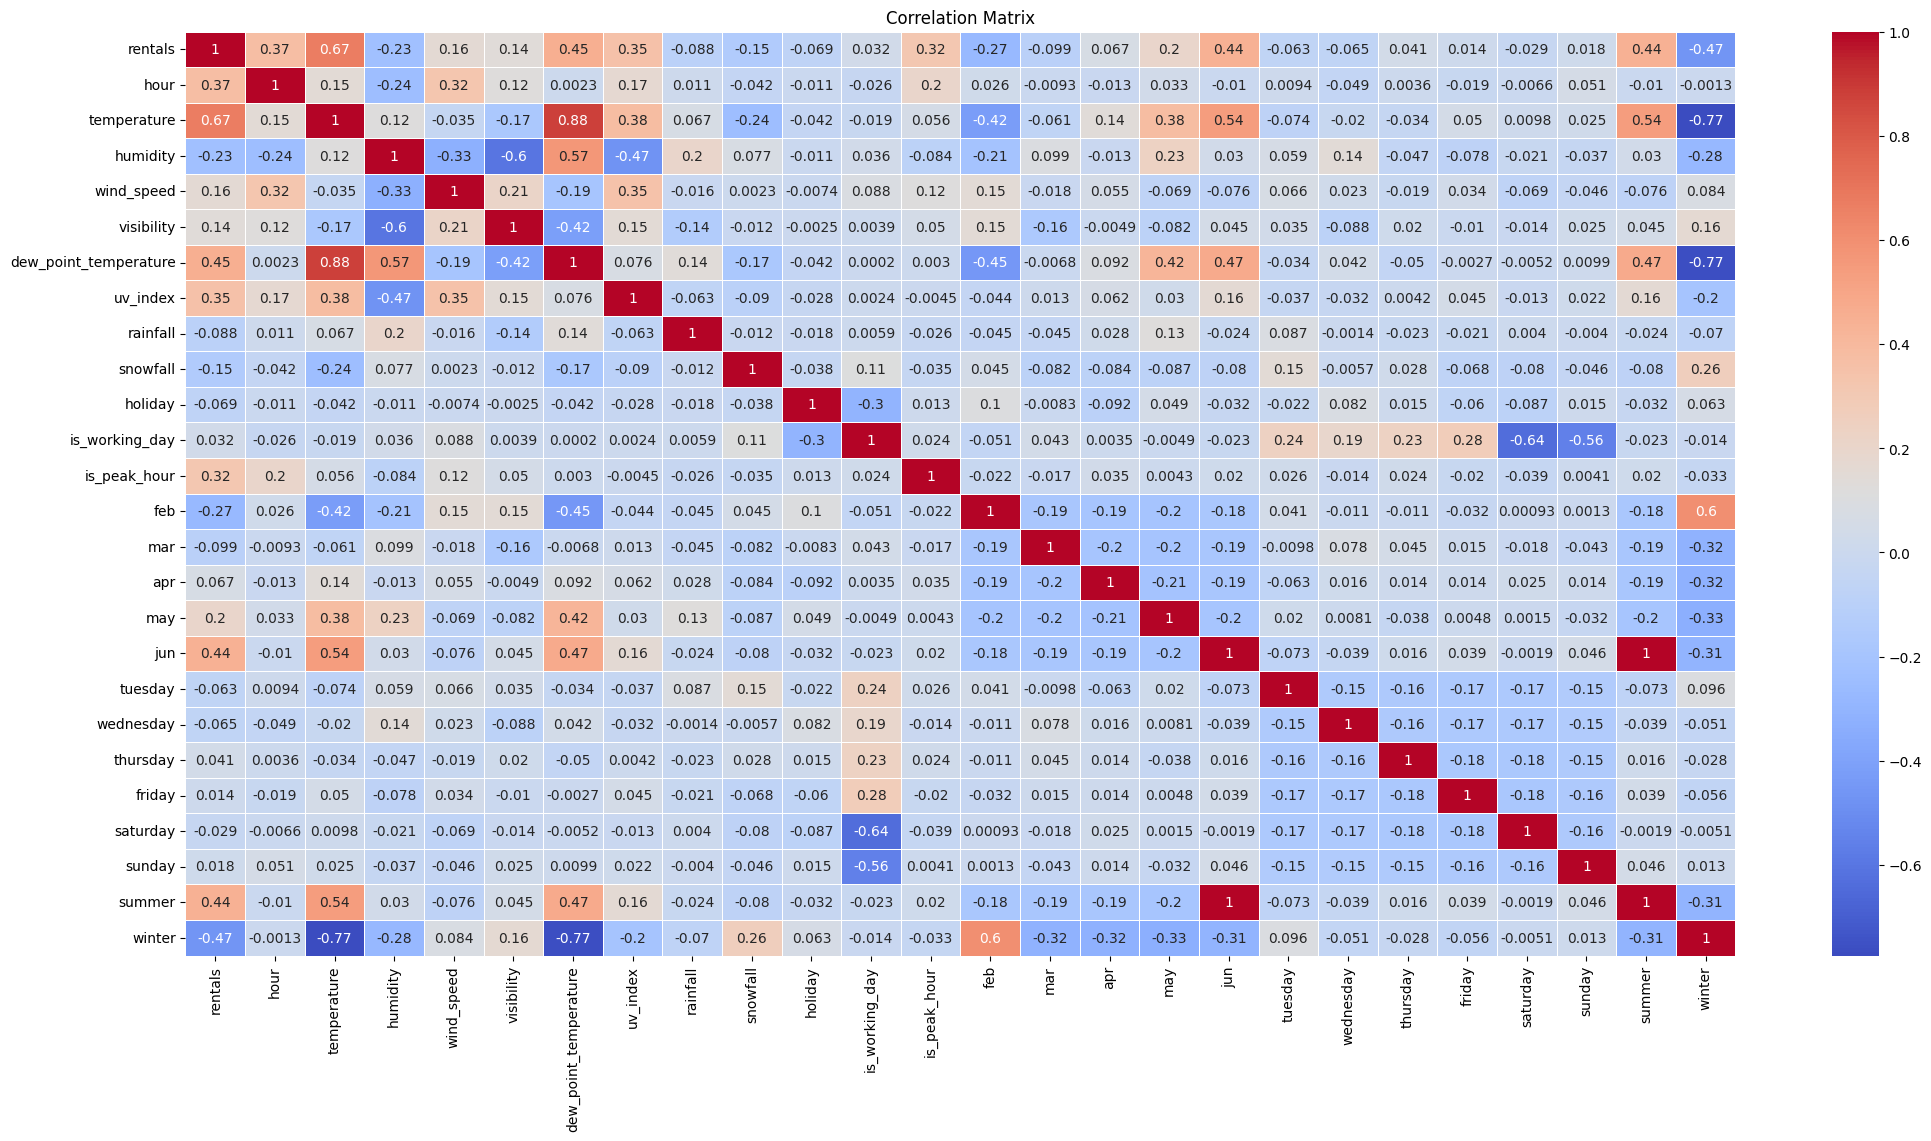

In [41]:
corr_matrix = bikerentals_complete.corr(numeric_only=True)

plt.figure(figsize=(25, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Matrix")
plt.show()